N_BNS =  28925
N_BNS_SGRB =  147
N_BNS_KN =  6333
N_BHNS =  34740
N_BHNS_SGRB =  3
N_BHNS_KN =  49


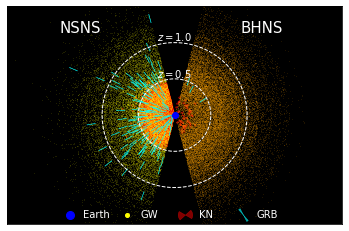

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from astropy.cosmology import Planck18 as cosmo
import h5py
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

def ell(thv,thc=3./180.*np.pi,a=4.):
    return (1.+(thv/thc)**4.)**(-a/4.)

def draw_jet(x0,y0,iota,thj,l,jet_color='aqua',alpha=0.6):
    r0 = np.sqrt(x0**2+y0**2)
    th0 = np.arctan2(y0,x0)
    
    x1j = x0+l*np.cos(th0+iota-thj)
    x2j = x0+l*np.cos(th0+iota+thj)
    y1j = y0+l*np.sin(th0+iota-thj)
    y2j = y0+l*np.sin(th0+iota+thj)
    
    x1cj = x0-l*np.cos(th0+iota-thj)
    x2cj = x0-l*np.cos(th0+iota+thj)
    y1cj = y0-l*np.sin(th0+iota-thj)
    y2cj = y0-l*np.sin(th0+iota+thj)
    
    plt.fill([x0,x1j,x2j,x2cj,x1cj,x0],[y0,y1j,y2j,y2cj,y1cj,y0],edgecolor=jet_color,facecolor=jet_color,alpha=alpha,zorder=2,lw=0.5,rasterized=True)

def draw_kn(x0,y0,iota,thkn,l,kn_color='red',alpha=0.5):

    r0 = np.sqrt(x0**2+y0**2)
    th0 = np.arctan2(y0,x0)
    
    phi = np.concatenate([[0.],np.linspace(-thkn/2.,thkn/2.,30),np.linspace(np.pi+thkn/2.,np.pi-thkn/2.,30),[0.]])
    xkn = x0+l*np.cos(phi+th0+iota+np.pi/2.)
    ykn = y0+l*np.sin(phi+th0+iota+np.pi/2.)
    xkn[0]=x0
    xkn[-1]=x0
    ykn[0]=y0
    ykn[-1]=y0
    
    plt.fill(xkn,ykn,edgecolor=kn_color,facecolor=kn_color,alpha=alpha,zorder=-2,lw=0.5,rasterized=True)
    

def bns_with_jet_and_kn(r,th,iota,jet,kn,lj=1.,lkn=0.5,thj=0.1,thkn=2.,alpha=0.2,color='yellow',jet_color='aqua',kn_color='r',size=3):
    x = r*np.cos(th)
    y = r*np.sin(th)
    
    # plot all systems
    plt.scatter(x,y,marker='o',s=size,alpha=alpha,c=color,linewidths=0.,rasterized=True)
    
    # plot jets
    for i in range(len(x[jet])):
        G0 = 100.
        b0 = (1.-G0**-2)**0.5
        thv = np.where(iota[jet][i]<(np.pi/2.),iota[jet][i],np.pi-iota[jet][i])
        doppler = G0**-1*(1.-b0*np.cos(np.maximum(thv-thj,0.)))**-1
        draw_jet(x[jet][i],y[jet][i],iota[jet][i],thj,lj,jet_color)
    
    # plot kne
    for i in range(len(x[kn])):
        draw_kn(x[kn][i],y[kn][i],iota[kn][i],thkn,lkn,kn_color)

th0 = np.linspace(0,2*np.pi,1000)
  
# BNS

NBNS = 1000000
dL_lim = cosmo.luminosity_distance(1.).to('cm').value

z0 = np.linspace(0.,10.,1000)
dVdz0 = cosmo.differential_comoving_volume(z0).to('Gpc3 / sr').value

np.random.seed(42)
years=5
NBNS = (11571//2)*years

BNSpop = h5py.File('./data_pop/nsns_1000000_SFHo_weight.hdf5','r')
w = BNSpop['weight']

p = w/np.sum(w)
i = np.sort(np.random.choice(np.arange(len(w)),NBNS,p=p))
detBNS = np.ones(NBNS,dtype=bool)
zBNS = BNSpop['z'][()][i] + 3e-3*np.random.normal(0.,1.,NBNS)
dLBNS = cosmo.luminosity_distance(zBNS).to('cm').value
iotaBNS = BNSpop['thv'][()][i]
jetBNS = BNSpop['det_prompt'][()][i] | BNSpop['det_after'][()][i]
knBNS = BNSpop['det_KN'][()][i]
#thBNS = np.pi+(-1)**np.random.randint(0,2,NBNS)*iotaBNS # phi = iota
thBNS = np.random.uniform(np.pi/2.+0.25,3*np.pi/2-0.25,NBNS)

print('N_BNS = ',np.sum(detBNS))
print('N_BNS_SGRB = ',np.sum(detBNS&jetBNS))
print('N_BNS_KN = ',np.sum(detBNS&knBNS))


# BHNS

NBHNS = (13896//2)*years

BHNSpop = h5py.File('./data_pop/bhns_1000000_SFHo_weight.hdf5','r')
w = BHNSpop['weight']

p = w/np.sum(w)
i = np.sort(np.random.choice(np.arange(len(w)),NBHNS,p=p))
detBHNS = np.ones(NBHNS,dtype=bool)
zBHNS = BHNSpop['z'][()][i] + 1e-2*np.random.normal(0.,1.,NBHNS)
dLBHNS = cosmo.luminosity_distance(zBHNS).to('cm').value
iotaBHNS = BHNSpop['thv'][()][i]
jetBHNS = BHNSpop['det_prompt'][()][i] | BHNSpop['det_after'][()][i]
knBHNS = BHNSpop['det_KN'][()][i]
#thBHNS = (-1)**np.random.randint(0,2,NBHNS)*iotaBHNS # phi = iota
thBHNS = np.random.uniform(2*np.pi+np.pi/2.-0.25,3*np.pi/2+0.25,NBHNS)


print('N_BHNS = ',np.sum(detBHNS))
print('N_BHNS_SGRB = ',np.sum(detBHNS&jetBHNS))
print('N_BHNS_KN = ',np.sum(detBHNS&knBHNS))

plt.subplot(111,facecolor='k')

# make z grid
zgrid = [0.5,1.]

for zg in zgrid:
    plt.plot(zg*np.cos(th0),zg*np.sin(th0),color='w',ls='--',alpha=1.,lw=1)
    tha = np.pi/2.
    plt.annotate(xy=(zg*np.cos(tha),zg*np.sin(tha)),text=r'$z=%.1f$'%zg,alpha=1.,rotation=90.-tha/np.pi*180.,color='w',ha='center',va='bottom')


# plot Earth
plt.plot([0],[0],marker='o',color='b')


bns_with_jet_and_kn(zBNS[detBNS],thBNS[detBNS],iotaBNS[detBNS],jetBNS[detBNS],knBNS[detBNS],lj=0.06,lkn=0.01,thj=0.05,size=0.4)
bns_with_jet_and_kn(zBHNS[detBHNS],thBHNS[detBHNS],iotaBHNS[detBHNS],jetBHNS[detBHNS],knBHNS[detBHNS],lj=0.05,lkn=0.015,thj=0.1,thkn=2.,size=0.4,jet_color='cyan',kn_color='r',color='orange')

plt.axis('equal')
plt.tick_params(which='both',top=False,bottom=False,right=False,left=False,labelbottom=False,labelleft=False)

zmax = 1.5

plt.annotate(xy=(-zmax+0.2,zmax-0.3),text='NSNS',fontsize=15,color='w',ha='center',va='center')
plt.annotate(xy=(zmax-0.3,zmax-0.3),text='BHNS',fontsize=15,color='w',ha='center',va='center')

plt.xlim(-zmax,zmax)
plt.ylim(-zmax,zmax)

# Posizioni per i simboli della legenda manuale
labels = ['Earth', 'GW', 'KN', 'GRB']
colors = ['b', 'yellow', 'red', 'aqua']
x_positions = np.linspace(-1.45, 0.95, len(labels))  # Spostato ulteriormente a sinistra
y_position = -1.38  # Abbassato leggermente

# Disegnare i simboli a mano nella parte inferiore del plot
for i, (label, color) in enumerate(zip(labels, colors)):
    if label == 'KN':
        draw_kn(x_positions[i], y_position, 0, np.pi/2.5, 0.1, kn_color=color)  # Reso ancora più largo
    elif label == 'GRB':
        draw_jet(x_positions[i], y_position, 0, np.pi/25, 0.1, jet_color=color)  # Ridotto ulteriormente
    elif label == 'GW':
        plt.plot(x_positions[i], y_position, marker='o', color=color, markersize=4)  # Punto giallo ridotto
    else:
        plt.plot(x_positions[i], y_position, marker='o', color=color, markersize=8)
    plt.text(x_positions[i] + 0.18, y_position - 0.03, label, color='white', ha='left', fontsize=10)

plt.show()